Epoch 0, Loss: 0.05434002305376731
Epoch 25, Loss: 0.02966736629838718
Epoch 50, Loss: 0.009299454372816606
Epoch 75, Loss: 0.003618674353593924
Epoch 100, Loss: 0.002589907936866664
Epoch 125, Loss: 0.0020564602627398017


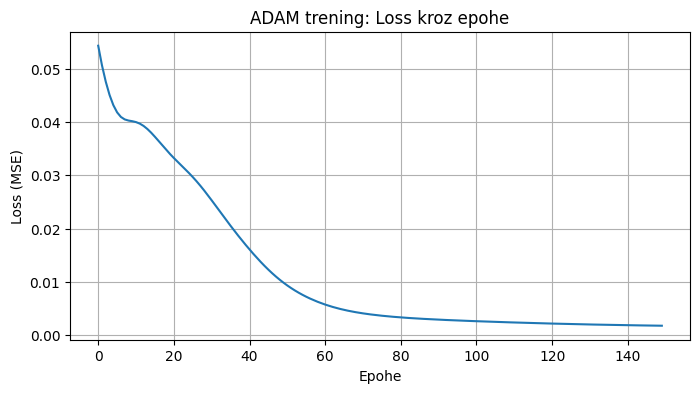

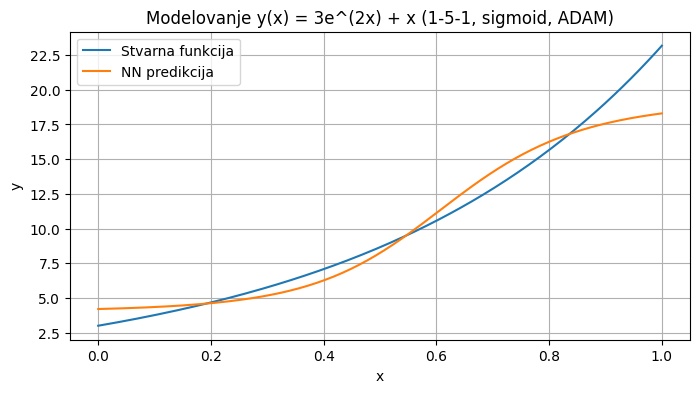

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Izvod sigmoida KADA JE ULAZ vec vrednost posle sigmoida (sigmoid_output)
def sigmoid_derivative(sigmoid_output):
    return sigmoid_output * (1 - sigmoid_output)

def std_fit(x):
    x_mean = np.mean(x, axis=0, keepdims=True)
    x_std  = np.std(x, axis=0, keepdims=True)
    return x_mean, x_std

def std_transform(x, x_mean, x_std):
    # +1e-12 da ne bi delili sa 0 ako je std slucajno 0
    return (x - x_mean) / (x_std + 1e-12)

def std_inverse(x_std_scaled, x_mean, x_std):
    return x_std_scaled * (x_std + 1e-12) + x_mean


# -------------------------------------------------------------------------- #
#                       MIN-MAX NORMALIZACIJA ZA y                            #
#   (ostaje zbog sigmoid izlaza: y mora biti u [0,1])                          #
# -------------------------------------------------------------------------- #

def minmax_fit(x):
    x_min = np.min(x, axis=0, keepdims=True)
    x_max = np.max(x, axis=0, keepdims=True)
    return x_min, x_max

def minmax_transform(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min + 1e-12)

def minmax_inverse(x_scaled, x_min, x_max):
    return x_scaled * (x_max - x_min + 1e-12) + x_min

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size,
                 learning_rate=0.03, beta1=0.9, beta2=0.996, eps=1e-8, seed=42):

        np.random.seed(seed)

        # Tezine i bijasi
        self.weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
        self.biases_hidden = np.zeros((1, hidden_size))

        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.biases_output = np.zeros((1, output_size))

        # Adam hiperparametri
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        # Adam memorija (m i v)
        self.m_wih = np.zeros_like(self.weights_input_hidden)
        self.v_wih = np.zeros_like(self.weights_input_hidden)

        self.m_bh = np.zeros_like(self.biases_hidden)
        self.v_bh = np.zeros_like(self.biases_hidden)

        self.m_who = np.zeros_like(self.weights_hidden_output)
        self.v_who = np.zeros_like(self.weights_hidden_output)

        self.m_bo = np.zeros_like(self.biases_output)
        self.v_bo = np.zeros_like(self.biases_output)

        # Brojac koraka za bias-correction (t u formulama)
        self.t = 0

    def forward(self, inputs):
        # Propagacija unapred
        self.hidden_layer_input = np.dot(inputs, self.weights_input_hidden) + self.biases_hidden
        self.hidden_layer_output = sigmoid(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.biases_output
        self.predicted_output = sigmoid(self.output_layer_input)

        return self.predicted_output

    def _adam_update(self, param, grad, m, v):
        # Jedan Adam korak (bias-correction)
        m = self.beta1 * m + (1 - self.beta1) * grad
        v = self.beta2 * v + (1 - self.beta2) * (grad * grad)

        m_hat = m / (1 - self.beta1 ** self.t)
        v_hat = v / (1 - self.beta2 ** self.t)

        param = param - self.learning_rate * (m_hat / (np.sqrt(v_hat) + self.eps))
        return param, m, v

    def backward(self, inputs, targets):
        n = inputs.shape[0]

        # dL/dy_hat (za MSE), pa kroz sigmoid
        output_error = (self.predicted_output - targets)
        output_delta = output_error * sigmoid_derivative(self.predicted_output)

        # Gradijenti za W2 i b2
        grad_who = np.dot(self.hidden_layer_output.T, output_delta) / n
        grad_bo = np.sum(output_delta, axis=0, keepdims=True) / n

        # Propagacija greske na skriveni sloj
        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * sigmoid_derivative(self.hidden_layer_output)

        # Gradijenti za W1 i b1
        grad_wih = np.dot(inputs.T, hidden_delta) / n
        grad_bh = np.sum(hidden_delta, axis=0, keepdims=True) / n

        # Adam update
        self.t += 1

        self.weights_hidden_output, self.m_who, self.v_who = self._adam_update(
            self.weights_hidden_output, grad_who, self.m_who, self.v_who
        )
        self.biases_output, self.m_bo, self.v_bo = self._adam_update(
            self.biases_output, grad_bo, self.m_bo, self.v_bo
        )

        self.weights_input_hidden, self.m_wih, self.v_wih = self._adam_update(
            self.weights_input_hidden, grad_wih, self.m_wih, self.v_wih
        )
        self.biases_hidden, self.m_bh, self.v_bh = self._adam_update(
            self.biases_hidden, grad_bh, self.m_bh, self.v_bh
        )

    def train(self, inputs, targets, epochs=150):
        loss_history = []

        for epoch in range(epochs):
            predicted_output = self.forward(inputs)

            # MSE loss
            loss = np.mean(0.5 * (targets - predicted_output) ** 2)
            loss_history.append(loss)

            self.backward(inputs, targets)

            if epoch % 25 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

        return loss_history

# Funkcija: y(x) = 3e^(2x) + x
np.random.seed(42)
X = np.random.rand(200, 1)          # x u [0,1]
y = 3 * np.exp(2 * X) + X           # bez suma

# 1) STANDARDIZACIJA X
x_mean, x_std = std_fit(X)
X_std = std_transform(X, x_mean, x_std)

# 2) y MORA ostati u [0,1] zbog sigmoid IZLAZA
y_min, y_max = minmax_fit(y)
y_norm = minmax_transform(y, y_min, y_max)

input_size = 1
hidden_size = 5
output_size = 1

learning_rate = 0.03
epochs = 150

omega1 = 0.9
omega2 = 0.996
eps = 1e-8

model = NeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    learning_rate=learning_rate,
    beta1=omega1,
    beta2=omega2,
    eps=eps,
    seed=42
)

loss_history = model.train(X_std, y_norm, epochs=epochs)

X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = 3 * np.exp(2 * X_test) + X_test

# Standardizujemo X_test istim mean/std kao trening
X_test_std = std_transform(X_test, x_mean, x_std)

# Predikcija u normalizovanom prostoru y
y_pred_norm = model.forward(X_test_std)

# Vracamo y u originalnu skalu
y_pred = minmax_inverse(y_pred_norm, y_min, y_max)

plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel("Epohe")
plt.ylabel("Loss (MSE)")
plt.title("ADAM trening: Loss kroz epohe")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(X_test, y_true, label="Stvarna funkcija")
plt.plot(X_test, y_pred, label="NN predikcija")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Modelovanje y(x) = 3e^(2x) + x (1-5-1, sigmoid, ADAM)")
plt.grid(True)
plt.legend()
plt.show()